In [53]:
import pandas as pd
import numpy as np
import shap

from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error as MSE 

from sklearn.metrics import accuracy_score

import lightgbm as lgb

# Dataset:
https://www.kaggle.com/c/titanic/overview

# Step 1

Get data and build a relevant model

Cross validation? Hyper parameters optimisation?

In [46]:
X = pd.read_csv('Titanic/train.csv')
y = X.Survived
X = X.drop(['Survived','PassengerId'],axis=1)

In [47]:
X_kaggle = pd.read_csv('Titanic/test.csv')

In [48]:
X['surname'] = X.Name.apply(lambda x: x.split(',')[0]).astype('category')
X = X.drop('Name',axis=1)

In [51]:
X = X.astype({'Sex':'category',
               'Ticket':'category',
               'Cabin':'category',
               'Embarked':'category'})

# Splitting 
train_X, test_X, train_y, test_y = train_test_split(X, y, 
                      test_size = 0.3, random_state = 123) 

In [57]:
gbm = lgb.LGBMClassifier(num_leaves=31,
                        learning_rate=0.05,
                        n_estimators=20)

gbm.fit(train_X, train_y,
        eval_set=[(test_X, test_y)],
        eval_metric='l1',
        early_stopping_rounds=5)

print('Starting predicting...')
# predict
y_pred = gbm.predict(test_X, num_iteration=gbm.best_iteration_)
# eval
print('The rmse of prediction is:', accuracy_score(test_y, y_pred))

[1]	valid_0's l1: 0.460541	valid_0's binary_logloss: 0.637004
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l1: 0.450635	valid_0's binary_logloss: 0.618093
[3]	valid_0's l1: 0.441765	valid_0's binary_logloss: 0.601978
[4]	valid_0's l1: 0.432642	valid_0's binary_logloss: 0.586313
[5]	valid_0's l1: 0.423929	valid_0's binary_logloss: 0.572071
[6]	valid_0's l1: 0.415619	valid_0's binary_logloss: 0.559135
[7]	valid_0's l1: 0.408168	valid_0's binary_logloss: 0.548048
[8]	valid_0's l1: 0.401071	valid_0's binary_logloss: 0.538079
[9]	valid_0's l1: 0.393874	valid_0's binary_logloss: 0.528001
[10]	valid_0's l1: 0.38752	valid_0's binary_logloss: 0.519473
[11]	valid_0's l1: 0.381152	valid_0's binary_logloss: 0.511203
[12]	valid_0's l1: 0.374828	valid_0's binary_logloss: 0.503197
[13]	valid_0's l1: 0.369076	valid_0's binary_logloss: 0.496221
[14]	valid_0's l1: 0.363531	valid_0's binary_logloss: 0.489854
[15]	valid_0's l1: 0.358102	valid_0's binary_logloss: 0.483549
[16]	

# Step 2 

- calculate Shap values for each observation in the train and test datasets
- add shap values to the datasets as additional features

In [105]:
def add_shap(X,model):

    explainer = shap.TreeExplainer(model)

    X_shap_values = explainer.shap_values(X)

    res = X.join(pd.DataFrame(X_shap_values[0], index=X.index, columns=X.columns),rsuffix='_SHAP')

    return res

In [107]:
train_X_extended = add_shap(train_X,gbm)
test_X_extended = add_shap(test_X,gbm)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [108]:
gbm.fit(train_X_extended, train_y,
        eval_set=[(test_X_extended, test_y)],
        eval_metric='l1',
        early_stopping_rounds=5)

print('Starting predicting...')
# predict
y_pred = gbm.predict(test_X_extended, num_iteration=gbm.best_iteration_)
# eval
print('The rmse of prediction is:', accuracy_score(test_y, y_pred))

[1]	valid_0's l1: 0.460482	valid_0's binary_logloss: 0.63691
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l1: 0.450318	valid_0's binary_logloss: 0.617686
[3]	valid_0's l1: 0.440782	valid_0's binary_logloss: 0.60053
[4]	valid_0's l1: 0.43152	valid_0's binary_logloss: 0.585079
[5]	valid_0's l1: 0.423645	valid_0's binary_logloss: 0.572473
[6]	valid_0's l1: 0.415506	valid_0's binary_logloss: 0.560421
[7]	valid_0's l1: 0.407776	valid_0's binary_logloss: 0.549303
[8]	valid_0's l1: 0.400381	valid_0's binary_logloss: 0.539027
[9]	valid_0's l1: 0.393378	valid_0's binary_logloss: 0.529826
[10]	valid_0's l1: 0.38689	valid_0's binary_logloss: 0.521823
[11]	valid_0's l1: 0.380728	valid_0's binary_logloss: 0.514655
[12]	valid_0's l1: 0.374236	valid_0's binary_logloss: 0.507221
[13]	valid_0's l1: 0.368966	valid_0's binary_logloss: 0.50201
[14]	valid_0's l1: 0.362912	valid_0's binary_logloss: 0.495472
[15]	valid_0's l1: 0.357942	valid_0's binary_logloss: 0.490954
[16]	vali

Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


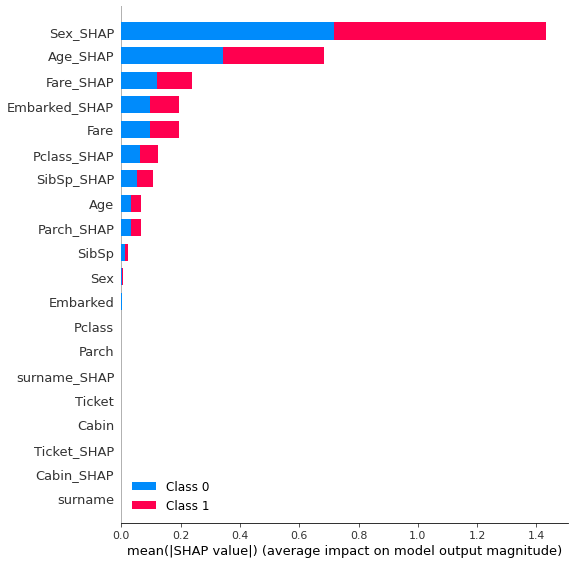

In [109]:
explainer = shap.TreeExplainer(gbm)

shap_values = explainer.shap_values(test_X_extended)

shap.summary_plot(shap_values, test_X_extended, max_display=100)

# Step 3

Build a new model with new features